In [68]:
from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
%matplotlib notebook

def parser(x):
    return datetime.strptime(x.replace("D",""),"%Y-%m-%d%H:%M:%S.%f000")

In [69]:
def load_df(ind, filename):
    try:
        data = pd.read_csv(filename, header=None, low_memory=True, dtype={0: str, 1: str,
                           3: float}, skiprows=2, na_values=0,parse_dates=[1],date_parser=parser)
    except Exception as e:
        print(e)
    return data

In [70]:
from multiprocessing import Pool
def load_dfs_mult(asset, files, location):
    #download_new(location)
    # multiprocessing version of load_df

    files.reverse()
    global files_
    files_ = files
    if 1 == 1:
        with Pool(processes=4) as pool:
            df_list = (pool.starmap(load_df, enumerate(files)))
            tqdm.pandas(desc="concat csvs")
            combined = pd.concat(df_list, ignore_index=True).progress_apply(lambda x: x)  # apply dummy lambda fn to call tqdm.pandas()
    print('loaded ' + str(combined.shape[0]) + ' ticks of data')
    return combined

In [71]:
import pandas as pd
import numpy as np
from tqdm import tqdm
def abcd(trend, skip_loop = 4, ma = 7):
    ma = pd.Series(trend).rolling(ma).mean().values
    x = []
    for a in (range(ma.shape[0])):
        for b in range(a, ma.shape[0], skip_loop):
            for c in range(b, ma.shape[0], skip_loop):
                for d in (range(c, ma.shape[0], skip_loop)):
                    if ma[b] > ma[a] and \
                    (ma[c] < ma[b] and ma[c] > ma[a]) \
                    and ma[d] > ma[b]:
                        x.append([a,b,c,d])
    x_np = np.array(x)
    print(x)
    ac = x_np[:,0].tolist() + x_np[:,2].tolist()
    bd = x_np[:,1].tolist() + x_np[:,3].tolist()
    ac_set = set(ac)
    bd_set = set(bd)
    signal = np.zeros(len(trend))
    buy = list(ac_set - bd_set)
    sell = list(list(bd_set - ac_set))
    signal[buy] = 1.0
    signal[sell] = -1.0
    return signal

In [73]:
series = load_dfs_mult("XBTUSD",["../20191218.csv","../20191219.csv","../20191220.csv"],"../")
print(series.head())

concat csvs: 100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


loaded 6859777 ticks of data
   0                          1       2
0  1 2019-12-20 00:00:02.555480  7148.0
1  2 2019-12-20 00:00:02.609596  7148.0
2  3 2019-12-20 00:00:02.612359  7148.0
3  4 2019-12-20 00:00:02.615343  7148.0
4  5 2019-12-20 00:00:02.617363  7148.0


In [74]:
series = series.drop(0,axis=1)
test = series.drop([0,1,2,3,4],axis=0)
test = test.set_index(1)
out = test.resample('10Min').ohlc()
sigs = abcd(out[2]['close']) # huge time consumer

Int64Index([0, 1, 2], dtype='int64')
Int64Index([2], dtype='int64')
                                 2
1                                 
2019-12-20 00:00:02.618790  7148.0
2019-12-20 00:00:02.619814  7148.0
2019-12-20 00:00:02.636970  7148.0
2019-12-20 00:00:03.205339  7148.0
2019-12-20 00:00:03.274518  7148.0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [75]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    states_money = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    
    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        states_money.append(initial_money)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, states_money

In [76]:
states_buy, states_sell, total_gains, invest, states_money = buy_stock(out[2]['close'], sigs)

day 6: buy 1 units at price 6636.000000, total balance 3364.000000
day 7: total balances 3364.000000, not enough money to buy a unit price 6649.000000
day 8: total balances 3364.000000, not enough money to buy a unit price 6659.000000
day 9: total balances 3364.000000, not enough money to buy a unit price 6649.500000
day 41: total balances 3364.000000, not enough money to buy a unit price 6618.500000
day 44: total balances 3364.000000, not enough money to buy a unit price 6593.500000
day 45: total balances 3364.000000, not enough money to buy a unit price 6612.000000
day 46: total balances 3364.000000, not enough money to buy a unit price 6615.500000
day 47: total balances 3364.000000, not enough money to buy a unit price 6614.000000
day 48: total balances 3364.000000, not enough money to buy a unit price 6642.500000
day 49: total balances 3364.000000, not enough money to buy a unit price 6645.500000
day 50: total balances 3364.000000, not enough money to buy a unit price 6631.000000
d

<IPython.core.display.Javascript object>


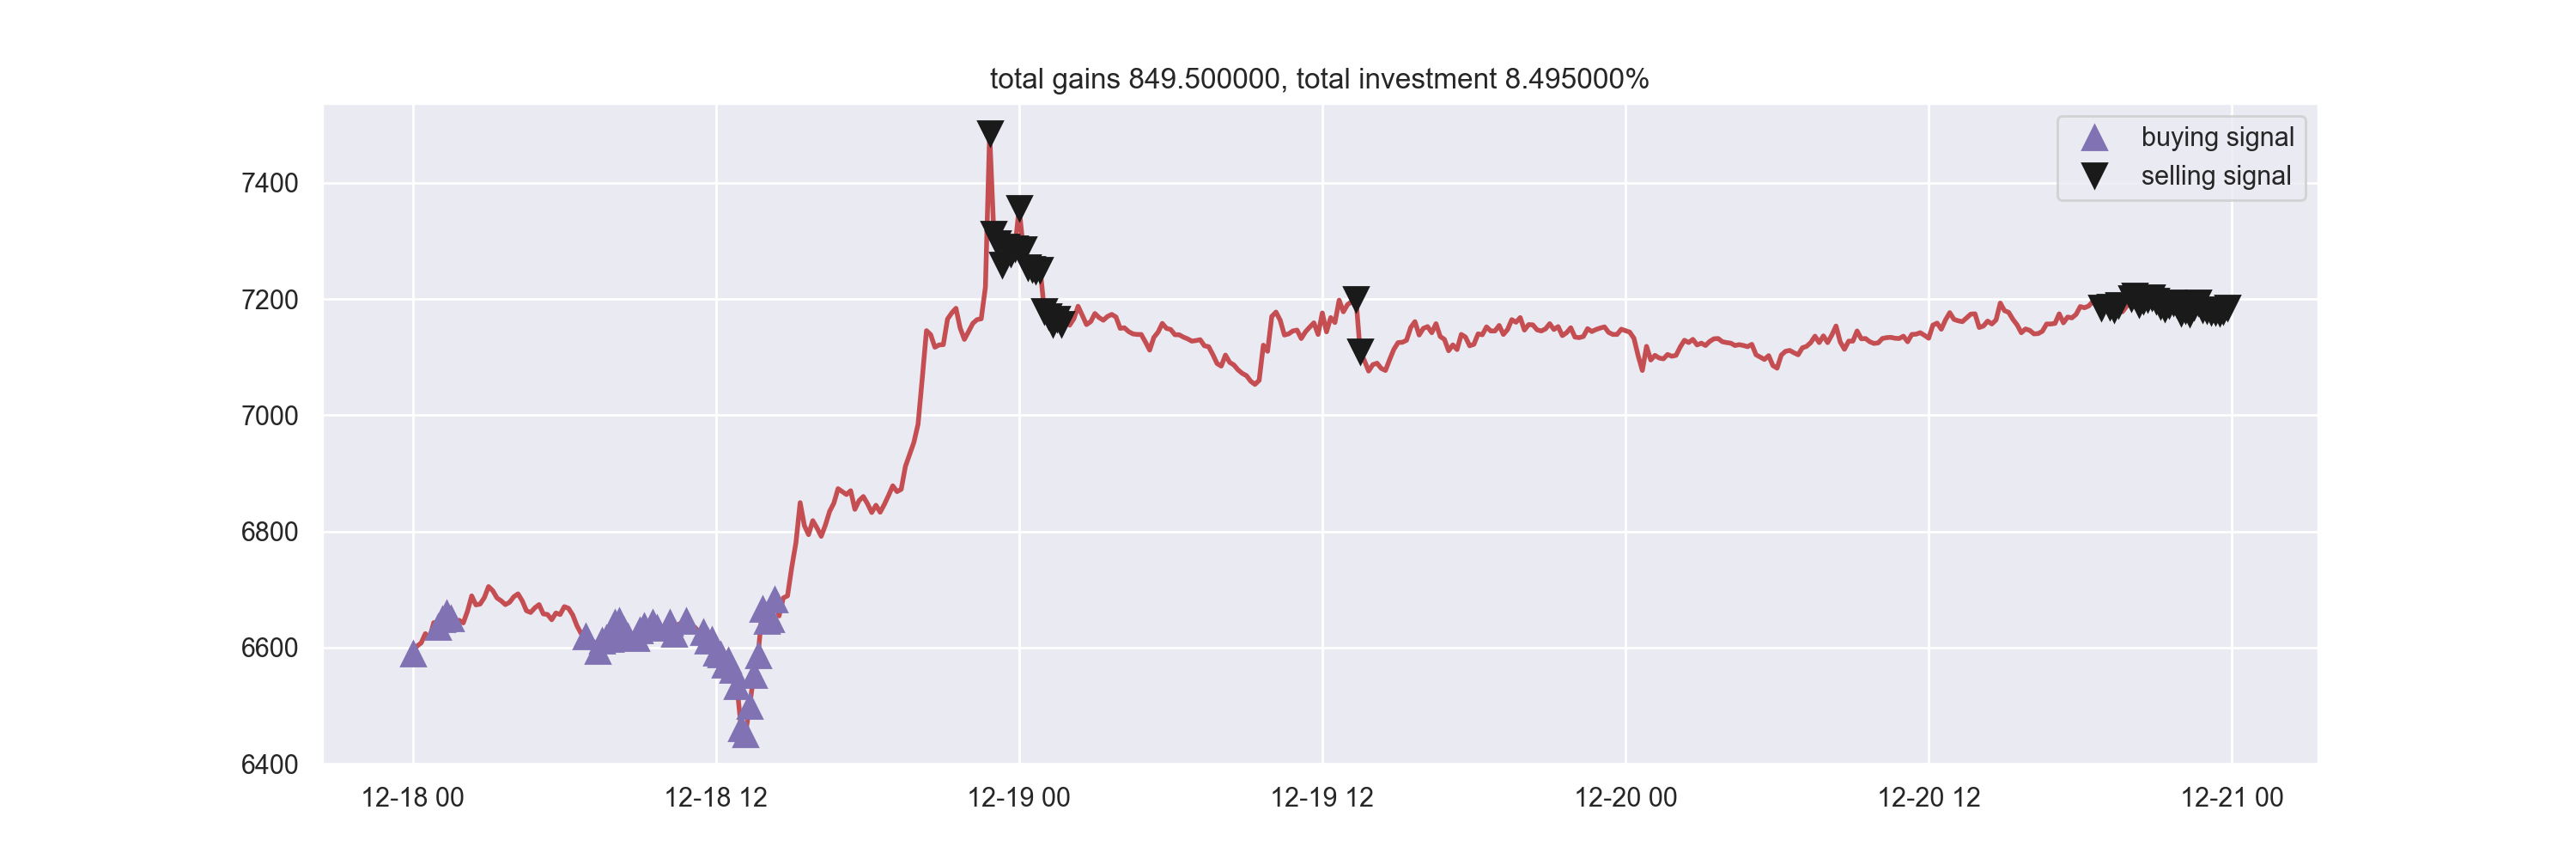

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
close = out[2]['close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()